In [82]:
import pandas as pd
import sklearn
import uproot
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model

import matplotlib.lines as mlinesZ
import json
import datetime
import time
import os
import warnings
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, scale
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import class_weight
plt.style.use('seaborn-deep')

# Use this line to enable GPU (only on applicable architecures)
# get_ipython().run_line_magic('env', 'CUDA_DEVICE_ORDER=PCI_BUS_ID')
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # turns off gpu
tf.test.is_gpu_available()


False

In [67]:
# fix random seed for reproducibility
seed = 100
np.random.seed(seed)


In [74]:
# Load tracks from stored pickle of ntuples
full_df = pd.read_pickle('/data/newhouse/LRT/batch/master/training/tracks_weighted.pkl')

In [75]:
# Inspect loaded dataframe
print("columns:", full_df.columns)
print("Total number of tracks loaded", len(full_df))
full_df.describe()

columns: Index(['numberOfPixelHoles', 'numberOfSCTHoles', 'numberOfSCTDoubleHoles',
       'numberOfContribPixelLayers', 'numberOfBLayerHits',
       'numberOfGangedFlaggedFakes', 'numberOfPixelHits', 'numberOfSCTHits',
       'standardDeviationOfChi2OS', 'track_pt', 'chiSquared', 'numberDoF',
       'numberOfBLayerSplitHits', 'numberOfInnermostLayerSplitHits',
       'numberOfInnermostPixelLayerHits',
       'numberOfNextToInnermostLayerSplitHits',
       'numberOfNextToInnermostPixelLayerHits', 'numberOfPixelSplitHits',
       'numberOfPixelOutliers', 'numberOfSCTOutliers',
       'numberOfPixelSpoiltHits', 'numberOfSCTSpoiltHits',
       'numberOfGangedPixels', 'numberOfOutliersOnTrack', 'eta', 'd0', 'z0',
       'phi0', 'theta', 'qOverP', 'score', 'linkValid', 'truthProbability',
       'signal', 'geometric_var', 'abs_z0', 'abs_d0', 'abs_eta', 'Sihits',
       'is_good', 'weights'],
      dtype='object')
Total number of tracks loaded 2989648


,numberOfPixelHoles,numberOfSCTHoles,numberOfSCTDoubleHoles,numberOfContribPixelLayers,numberOfBLayerHits,numberOfGangedFlaggedFakes,numberOfPixelHits,numberOfSCTHits,standardDeviationOfChi2OS,track_pt,...,theta,qOverP,score,truthProbability,geometric_var,abs_z0,abs_d0,abs_eta,Sihits,weights
count,2.989648e+06,2.989648e+06,2989648.0,2.989648e+06,2989648.0,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,...,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2989648.0
mean,2.074729e-01,2.657768e-01,0.0,1.079176e+00,-1.0,1.592997e-02,1.133434e+00,7.916095e+00,1.144905e+02,2.900017e+04,...,1.563522e+00,2.982623e-05,3.617784e+02,7.400980e-01,1.186394e+00,1.562124e+02,5.442146e+01,1.145800e+00,9.049529e+00,1.0
std,4.054972e-01,4.417460e-01,0.0,1.045883e+00,0.0,1.263800e-01,1.149012e+00,1.070428e+00,3.969355e+03,3.830809e+07,...,9.440221e-01,4.257649e-04,2.489364e+03,2.430430e-01,8.933309e-01,1.320602e+02,5.534037e+01,6.949590e-01,1.476998e+00,0.0
min,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-1.0,0.000000e+00,0.000000e+00,2.000000e+00,-1.000000e+00,1.000001e+03,...,1.348850e-01,-9.998488e-04,7.758226e-05,1.000000e-01,4.063888e-07,3.377415e-05,7.760171e-06,3.486286e-06,6.000000e+00,1.0
25%,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-1.0,0.000000e+00,0.000000e+00,7.000000e+00,5.000000e+01,1.187536e+03,...,6.277133e-01,-2.747647e-04,9.017683e-03,5.555556e-01,3.618336e-01,4.351445e+01,1.208131e+01,5.565343e-01,8.000000e+00,1.0
50%,0.000000e+00,0.000000e+00,0.0,1.000000e+00,-1.0,0.000000e+00,1.000000e+00,8.000000e+00,8.200000e+01,1.519313e+03,...,1.559468e+00,5.101321e-05,2.027286e-02,7.777778e-01,9.921221e-01,1.150353e+02,3.297317e+01,1.113044e+00,8.000000e+00,1.0
75%,0.000000e+00,1.000000e+00,0.0,2.000000e+00,-1.0,0.000000e+00,2.000000e+00,8.000000e+00,1.360000e+02,2.545154e+03,...,2.499675e+00,3.326354e-04,3.223465e-01,1.000000e+00,2.002212e+00,2.517706e+02,8.100210e+01,1.668462e+00,1.000000e+01,1.0
max,1.000000e+00,1.000000e+00,0.0,6.000000e+00,-1.0,3.000000e+00,9.000000e+00,1.800000e+01,3.189489e+06,6.623324e+10,...,3.006237e+00,9.997356e-04,1.096304e+06,1.000000e+00,3.002888e+00,4.999996e+02,2.998766e+02,2.694963e+00,2.100000e+01,1.0


In [78]:
# now shuffle by sampling
df = full_df.sample(frac=1)


variables.json written to /data/newhouse/LRT/batch/master/trainingmodel


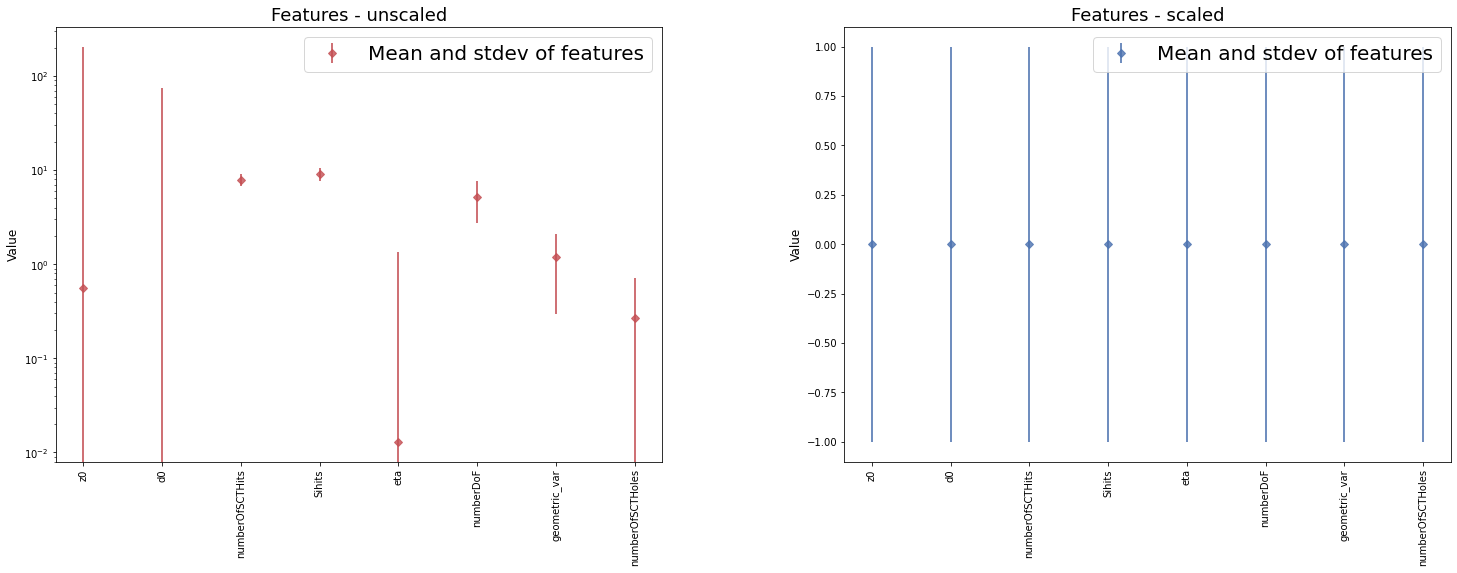

In [79]:
### Select relevant features and scale them
# This could be done with a scikitlearn utility, but we're interested in recording the exact values of scaling and offset.
# The LWTNN library uses scaling and offset information for each variable to automatically 
# pre-process the variables within athena.
dir_name = '/data/newhouse/LRT/batch/master/training'

label_names = ["is_good"]

# redefined based on permutation importance
inputs_names = [ 
"z0",
"d0",
"numberOfSCTHits",
"Sihits",
"eta",
"numberDoF",
"geometric_var",
"numberOfSCTHoles",
]

# Prepare for saving information to lwtnn
# See https://github.com/dguest/lwtnn-tutorial-for-btaggers for motivation for this section
variables_json = {'inputs': [],
                  'class_labels': ["nn_score"]}

# Manual scaling to save scale and offset params for lwtnn (otherwise could use skliearn scale)
X = np.array(df[inputs_names])
X_mean = X.mean(axis=0)
X = X - X_mean # offset
X_std = X.std(axis=0)
# Don't divide by 0. These values are all the same (probably zero) and will be ignored as null values in training.
X_std[X_std==0] = 1
X = X/X_std # scale
for i in range(len(inputs_names)):
    variable_dict = {'name': inputs_names[i], 'offset': -X_mean[i], 'scale': 1/X_std[i] }
    variables_json['inputs'].append(variable_dict)

# now we save some things (create a subdirectory to keep it clean)
model_dir = dir_name+'model'
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
print()
with open('{}/variables.json'.format(model_dir),'w') as variables:
    variables.write(json.dumps(variables_json, indent=2))
print("variables.json written to {}".format(model_dir))
    
# Don't scale this. Keep the labels binary
Y = np.array(df[label_names])

# Split into training and validation sets
X_train = X[0 : int(0.8*len(X))]
X_val =  X[int(0.8*len(X)) : len(X)]
Y_train = Y[0 : int(0.8*len(Y))]
Y_val =  Y[int(0.8*len(Y)) : len(Y)]

# Keep track of the weights
train_weights = df.weights[0 : int(0.8*len(X))]
val_weights =  df.weights[int(0.8*len(X)) : len(X)]

# Check the samples are consistent
assert(len(X_train) == len(Y_train))
assert(len(X_train) == len(train_weights))
assert(len(X_val) == len(Y_val))
assert(len(X_val) == len(val_weights))

# Plot features
X_mean_new = X.mean(axis=0)
X_std_new = X.std(axis=0)

labels = inputs_names
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,8))
ax1.semilogy(labels, np.array(X_mean), alpha=0, label='Track')
unscaled = ax1.errorbar(labels, np.array(X_mean), yerr=X_std, fmt='D', color='#C44E52', ecolor='#C44E52', linewidth=2, alpha = 0.8, label='_nolegend_')
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend([unscaled],["Mean and stdev of features"], fontsize=20)
ax1.set_title("Features - unscaled", fontsize=18)
ax1.set_ylabel("Value", fontsize=12)

ax2.plot(labels, np.array(X_mean_new), alpha=0, label='Track')
scaled = ax2.errorbar(labels, np.array(X_mean_new), yerr=X_std_new, fmt='D', color='#4C72B0', ecolor='#4C72B0', linewidth=2, alpha = 0.8, label='_nolegend_')
ax2.xaxis.set_tick_params(rotation=90)
ax2.legend([scaled],["Mean and stdev of features"], fontsize=20)
ax2.set_title("Features - scaled", fontsize=18)
ax2.set_ylabel("Value", fontsize=12)

plt.subplots_adjust(wspace = 0.3)

In [83]:
### Callback functions

# Functions for visualization
# These are useful plots to watch when in a notebook environment
# They should show the learning curves of the loss function and the accuracy metric

# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.pred_good = np.array([])
        self.pred_fake = np.array([])
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharex=False)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Training set loss")
        ax1.plot(self.x, self.val_losses, label="Validation set loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="Training set accuracy")
        ax2.plot(self.x, self.val_acc, label="Validation set accuracy")
        ax2.legend()
        
        if (epoch % 10 == 0):
            predictions = model.predict(X_val)
            self.pred_good = predictions[Y_val.flatten() == 1]
            self.pred_fake = predictions[Y_val.flatten() == 0]

        x = [self.pred_good, self.pred_fake]
        edgecolors = ['#4C72B0','#55A868']
        for i in [0,1]:
            ax3.hist(x[i], edgecolor=edgecolors[i], histtype='step', linewidth=2.5, alpha=0.85, density=1, bins = np.linspace(0,1,90))
        ax3.set_xlabel("Value", fontsize=12)
        ax3.set_ylabel("Tracks", fontsize=12)
        ax3.set_title("NN precidction", fontsize=18)
        ax3.legend(['good', 'fake'], loc='upper center')
#         ymin, ymax = plt.ylim()
#         plt.ylim(ymin,ymax*1.1)
        plt.show();
        
plot = PlotLearning()


checkpoint_path = dir_name + "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)

# Create checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_weights_only=True,
                                                  save_best_only=True,
                                                  monitor='val_loss', 
                                                  mode='min',
                                            )

# Create early stopping callback
early_stop = EarlyStopping(patience=40, restore_best_weights=True)


class GetBest(Callback):
    """Get the best model at the end of training.
    # Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
    # Example
        callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
        mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)
        
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [84]:
### Define the network
# Different architectures have been tested but not rigorously. A grid search my help find optimal hyperparameters.

n_variables = X_train.shape[1]
print("Input tensor shape (examples, features):", X_train.shape)

# Create model
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(n_variables, input_dim=n_variables, activation='relu'))
    model.add(keras.layers.Dense(n_variables*3, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(n_variables*2, activation='relu'))
#     model.add(keras.layers.Dropout(rate=0.1, seed=1))
    model.add(keras.layers.Dense(n_variables, activation='relu'))
    model.add(keras.layers.Dense(n_variables, activation='relu'))
#     model.add(keras.layers.Dropout(rate=0.1, seed=1))
#     model.add(keras.layers.Dense(12, input_dim=n_variables, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer = keras.optimizers.Adamax(lr=0.0003),
                  metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

model = create_model()
print(model.summary())

Input tensor shape (examples, features): (2391718, 8)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 905
Trainable params: 905
Non-trainable params: 0
__

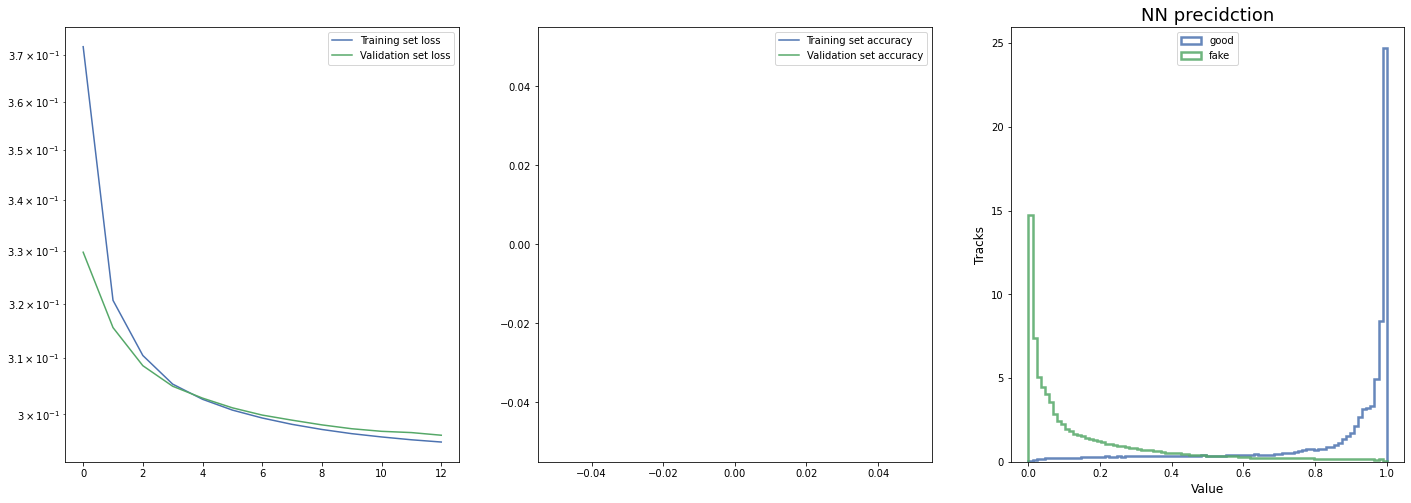

4784/4784 [==============================] - 48s 10ms/step - loss: 0.2952 - accuracy: 0.8723 - f1_m: 0.8697 - precision_m: 0.8865 - recall_m: 0.8539 - val_loss: 0.2964 - val_accuracy: 0.8713 - val_f1_m: 0.8696 - val_precision_m: 0.8799 - val_recall_m: 0.8600
Epoch 14/10000
  58/4784 [..............................] - ETA: 12s - loss: 0.2985 - accuracy: 0.8682 - f1_m: 0.8654 - precision_m: 0.8813 - recall_m: 0.8504

/home/newhouse/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: Can pick best model only with val_acc available, skipping.


 608/4784 [==>...........................] - ETA: 22s - loss: 0.2947 - accuracy: 0.8722 - f1_m: 0.8700 - precision_m: 0.8861 - recall_m: 0.8549

KeyboardInterrupt: 

In [85]:
### Train model, this will take some time
# Note: this cell can be run again to train even more, as long as the model is not re-made, the optomizer will maintain its last state

# Fit the model
history = model.fit(X_train, Y_train, epochs=10000, batch_size=500 , 
                    callbacks=[plot, early_stop, GetBest(monitor='val_acc', verbose=1, mode='max') ], 
                    validation_data=(X_val, Y_val, ),
#                     sample_weight = train_weights
                   )

In [86]:
# Rough evaluation of the model. See below for more precise metrics.
scores = model.evaluate(X_val, Y_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

18686/18686 [==============================] - 64s 3ms/step - loss: 0.2962 - accuracy: 0.8713 - f1_m: 0.8657 - precision_m: 0.8820 - recall_m: 0.8573

accuracy: 87.13%


In [87]:
### Saving the model
# Now that the model is trained, we want to save it in a format that lwtnn can use
# the lwtnn converters prefer specific formats of network models and weights.
# The lines below should save things correctly

# Create a time-stamped subdirectory to keep clean records
model_dir = dir_name+'model/'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the architecture as json
with open('{}/arch.json'.format(model_dir),'w') as archetecture:
    archetecture.write(model.to_json(indent=2, sort_keys=True) )
    
# Save the weights as hdf5
model.save_weights('{}/weights.h5'.format(model_dir), save_format='h5')

# Save the variables (calculated in previous section)
with open('{}/variables.json'.format(model_dir),'w') as variables:
    variables.write(json.dumps(variables_json, indent=2))
# print("variables.json written to {}".format(model_dir))

# Save the summary. Lwtnn doesn't require this but it can be good reference.
with open('{}/summary.txt'.format(model_dir),'w') as summary:
    model.summary(print_fn=lambda x: summary.write(x + '\n'))

# Additionally we can save the network in a format that Keras can pick up and use later
# Note: the optimizer state cannot be saved, so the network cannot be trained on further
# from its current state, but it can be used to evaluate new samples and analyze performance
model.save('{}/model-keras.json'.format(model_dir))
    
print("Model saved to {}/".format(model_dir))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /data/newhouse/LRT/batch/master/trainingmodel/20200707_134123/model-keras.json/assets
Model saved to /data/newhouse/LRT/batch/master/trainingmodel/20200707_134123/


In [88]:
# We can take care of converting the network to lwtnn format right here
# Note: This converter is slightly different than the one the current version of lwtnn at the time of this writing
# I needed to make a small change in the structure of the converter.
# k2j = './converters/keras2json.py'
k2j = 'converters/keras2json.py'
k2j_command = k2j + " {0}/arch.json {0}/variables.json {0}/weights.h5 > {0}/nn-config.json".format((model_dir))
# print(k2j_command)
if(os.system(k2j_command) == 0): print("Success, model saved in lwtnn format\n{}/nn-config.json".format(model_dir))
else: print("Failed to save model")
    

Success, model saved in lwtnn format
/data/newhouse/LRT/batch/master/trainingmodel/20200707_134123/nn-config.json


In [89]:
# # in case you want to load an old model
if False:
    model_dir_load = "/fast_scratch/rnewhous/LRT/training/model/20200522_041924_minimal_outputs/"
    json_file = open(model_dir_load+'arch.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights(model_dir_load+'weights.h5')
    model = loaded_model
    print("Loaded model from disk")
    model.compile(loss='binary_crossentropy', 
                  optimizer = keras.optimizers.Adamax(lr=0.0003),
                  metrics=['accuracy', f1_m, precision_m, recall_m])


# # keras.models.model_from_json("")

In [90]:
### Evaluate the network's performance
# Now we can look in-depth at the performance of the neural network in separating the classes
# Remember however that this is only a proxy to the true metric of performance: efficiency and fake rate
# in athena's track reconstruction algorithm. That depends on relative ordering and cannot be evaluated here
# We can however measure the discrimination power and assume that it translates to preferred ordering.

# evaluate predictions
predictions = model.predict(X_val)
print("predictions finished")
predictions_cut = predictions>0.5
print("cut finished")

predictions finished
cut finished


In [91]:
# It can be useful when comparing models later on to save additional performance stats to the model directory
# https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234
model_performance = {}
    
model_performance['accuracy_score'] = accuracy_score(y_true=Y_val, y_pred=predictions_cut)
print("Accuracy %.4f" % model_performance['accuracy_score'])
model_performance['f1_score'] = f1_score(y_true=Y_val, y_pred=predictions_cut)
print("F1 Score %.4f" % model_performance['f1_score'])
model_performance['precision_score'] = precision_score(y_true=Y_val, y_pred=predictions_cut)
print("Precision %.4f" % model_performance['precision_score'])
model_performance['recall_score'] = recall_score(y_true=Y_val, y_pred=predictions_cut)
print("Recall %.4f" % model_performance['recall_score'])
model_performance['confusion_matrix'] = confusion_matrix(y_true=Y_val, y_pred=predictions_cut)
print("Confusion Matrix: \n", model_performance['confusion_matrix'])    

with open('{}/model_performance.json'.format(model_dir),'w') as model_performance_file:
    json.dump(str(model_performance), model_performance_file)
print("saved to {}/model_performance.json".format(model_dir))

Accuracy 0.8713
F1 Score 0.8694
Precision 0.8821
Recall 0.8572
Confusion Matrix: 
 [[264788  34258]
 [ 42691 256193]]
saved to /data/newhouse/LRT/batch/master/trainingmodel/20200707_134123/model_performance.json


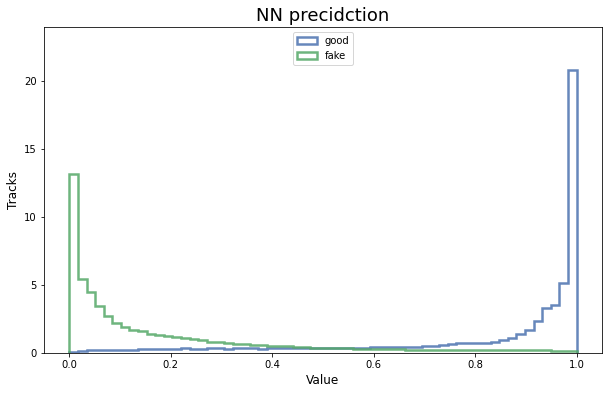

<Figure size 432x288 with 0 Axes>

In [92]:
# Visualize the NN dicriminant evaluated on good and fake tracks

pred_good = predictions[Y_val.flatten() == 1]
pred_fake = predictions[Y_val.flatten() == 0]

fig, ax1 = plt.subplots(1, 1,figsize=(10,6))
x = [pred_good, pred_fake]
edgecolors = ['#4C72B0','#55A868']
for i in [0,1]:
    ax1.hist(x[i], edgecolor=edgecolors[i], histtype='step', linewidth=2.5, alpha=0.85, density=1, bins = np.linspace(0,1,60))
ax1.set_xlabel("Value", fontsize=12)
ax1.set_ylabel("Tracks", fontsize=12)
ax1.set_title("NN precidction", fontsize=18)
ax1.legend(['good', 'fake'], loc='upper center')
# ax1.set_yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(ymin,ymax*1.1)
plt.show()
plt.savefig('{}/discriminant.png'.format(model_dir),)

# From a previous study where we would cut on some nn value to remove fakes
# for cut in [0.05,0.1,0.2,0.5,0.8]:
#     total_fake = len(pred_fake)
#     remaining_fake = len(pred_fake[pred_fake>=cut])
#     print("Cutting at {}: remaining fakes: {:.2%}".format(cut, remaining_fake/total_fake))
#     total_good = len(pred_good)
#     remaining_good = len(pred_good[pred_good>=cut])
#     print("                remaining goods: {:.2%}".format(remaining_good/total_good))
    

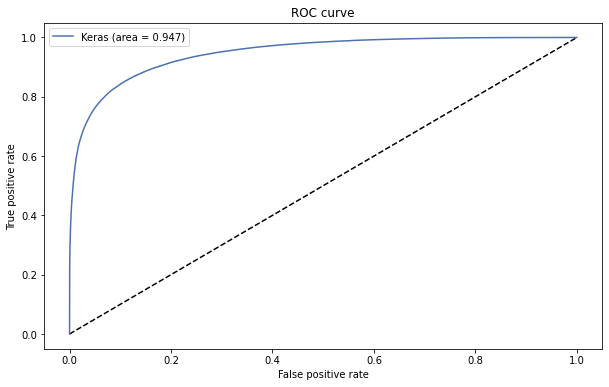

<Figure size 432x288 with 0 Axes>

In [93]:
# Plotting the ROC curve
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
y_pred_keras = predictions.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_val, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1, (10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('{}/roc.png'.format(model_dir),)
# # Zoom in view of the upper left corner.
# plt.figure(2, (10,6))
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [66]:
################### End of useful stuff. Things beyond here are just for fun. They may not work #######################

In [95]:
# Permutation importance. i.e. which features were the most important
# https://www.kaggle.com/dansbecker/permutation-importance
import eli5
from eli5.sklearn import PermutationImportance
Y_df = pd.DataFrame(Y_val.ravel() == 1, columns=label_names)
X_df = pd.DataFrame(X_val, columns=inputs_names)
print(Y_df.values.flatten().shape)
print(X_df.shape)

(597930,)
(597930, 8)


/home/newhouse/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/newhouse/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [97]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

my_model = KerasClassifier(build_fn=create_model)    
my_model.fit(X_train,Y_train, epochs=100, batch_size = 500)

Epoch 1/100
4784/4784 [==============================] - 28s 6ms/step - loss: 0.3981 - accuracy: 0.8238 - f1_m: 0.8182 - precision_m: 0.8541 - recall_m: 0.7903
Epoch 2/100
4784/4784 [==============================] - 36s 7ms/step - loss: 0.3231 - accuracy: 0.8644 - f1_m: 0.8604 - precision_m: 0.8846 - recall_m: 0.8380
Epoch 3/100
4784/4784 [==============================] - 44s 9ms/step - loss: 0.3126 - accuracy: 0.8673 - f1_m: 0.8641 - precision_m: 0.8843 - recall_m: 0.8453
Epoch 4/100
4784/4784 [==============================] - 72s 15ms/step - loss: 0.3074 - accuracy: 0.8687 - f1_m: 0.8655 - precision_m: 0.8856 - recall_m: 0.8468
Epoch 5/100
4784/4784 [==============================] - 61s 13ms/step - loss: 0.3042 - accuracy: 0.8698 - f1_m: 0.8667 - precision_m: 0.8866 - recall_m: 0.8482
Epoch 6/100
4784/4784 [==============================] - 50s 10ms/step - loss: 0.3019 - accuracy: 0.8708 - f1_m: 0.8678 - precision_m: 0.8871 - recall_m: 0.8498
Epoch 7/100
4784/4784 [==============

4784/4784 [==============================] - 47s 10ms/step - loss: 0.2882 - accuracy: 0.8750 - f1_m: 0.8726 - precision_m: 0.8883 - recall_m: 0.8580
Epoch 52/100
4784/4784 [==============================] - 39s 8ms/step - loss: 0.2882 - accuracy: 0.8750 - f1_m: 0.8726 - precision_m: 0.8883 - recall_m: 0.8580
Epoch 53/100
4784/4784 [==============================] - 47s 10ms/step - loss: 0.2881 - accuracy: 0.8750 - f1_m: 0.8726 - precision_m: 0.8883 - recall_m: 0.8580
Epoch 54/100
4784/4784 [==============================] - 59s 12ms/step - loss: 0.2880 - accuracy: 0.8751 - f1_m: 0.8727 - precision_m: 0.8883 - recall_m: 0.8582
Epoch 55/100
4784/4784 [==============================] - 44s 9ms/step - loss: 0.2880 - accuracy: 0.8751 - f1_m: 0.8728 - precision_m: 0.8884 - recall_m: 0.8581
Epoch 56/100
4784/4784 [==============================] - 50s 10ms/step - loss: 0.2880 - accuracy: 0.8752 - f1_m: 0.8728 - precision_m: 0.8884 - recall_m: 0.8583
Epoch 57/100
4784/4784 [===================

In [69]:
perm = PermutationImportance(my_model, random_state=1).fit(X_val,Y_val, epochs=3, batch_size = 100000)

88253/88253 [==============================] - 3s 30us/sample - loss: 0.4471 - acc: 0.7948 - f1_m: 0.7854 - precision_m: 0.8038 - recall_m: 0.7788


In [98]:
eli5.show_weights(perm, feature_names = X_df.columns.tolist(), top=100)

NameError: name 'perm' is not defined

In [38]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots


# Create the data that we will plot
pdp_goals = {}
pdp_goals['z0'] = pdp.pdp_isolate(model=my_model, dataset=X_df, model_features=X_df.columns.tolist(), feature='z0')
pdp_goals['d0'] = pdp.pdp_isolate(model=my_model, dataset=X_df, model_features=X_df.columns.tolist(), feature='d0')
pdp_goals['numberOfSCTHits'] = pdp.pdp_isolate(model=my_model, dataset=X_df, model_features=X_df.columns.tolist(), feature='numberOfSCTHits')
pdp_goals['track_eta'] = pdp.pdp_isolate(model=my_model, dataset=X_df, model_features=X_df.columns.tolist(), feature='track_eta')
pdp_goals['geometricVariable'] = pdp.pdp_isolate(model=my_model, dataset=X_df, model_features=X_df.columns.tolist(), feature='geometricVariable')
pdp_goals['numberOfSCTHoles'] = pdp.pdp_isolate(model=my_model, dataset=X_df, model_features=X_df.columns.tolist(), feature='numberOfSCTHoles')


In [42]:
features_to_plot = ['numberOfSCTHits', 'geometricVariable']
inter1  =  pdp.pdp_interact(my_model, dataset=X_df, model_features=X_df.columns.tolist(), features=features_to_plot)